In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
train_size = 150
test_size = 5
return_day = 10
extreme_val = 0
full_size = train_size + test_size + return_day 
# make return_day long gap between train and test set to avoid lookahead bias

In [4]:
data = pd.read_excel('USDCLP.xlsx', skiprows=4, index_col='Dates', parse_dates=True)
data.dropna(inplace=True)
data.columns = ['Open', 'High', 'Low', 'Close']
data = data['2004':] # before 2004 the data is not OHLC, but C
data['2018-01-08':'2018-01-13']

,Open,High,Low,Close
Dates,,,,
2018-01-08,606.37,608.47,604.58,605.31
2018-01-09,606.00,608.59,605.57,607.89
2018-01-10,607.66,610.70,606.23,609.32
2018-01-11,608.01,609.67,606.13,606.22
2018-01-12,603.17,605.81,602.86,603.18


In [5]:
new_data = data.resample('1W').pad()
new_data['Open'] = data['Open'].resample('1W').first()
new_data['Close'] = data['Close'].resample('1W').last()
new_data['High'] = data['High'].resample('1W').max()
new_data['Low'] = data['Low'].resample('1W').min()
new_data.dropna(inplace=True)
new_data.tail()

,Open,High,Low,Close
Dates,,,,
2018-01-07,612.19,612.45,601.80,605.78
2018-01-14,606.37,610.70,602.86,603.18
2018-01-21,599.58,608.82,599.31,608.21
2018-01-28,607.69,609.78,597.70,601.68
2018-02-04,603.65,607.37,596.31,597.03


In [6]:
data = new_data

In [7]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [8]:
features_to_delete = data.columns.tolist()

# ROC

In [9]:
for i in [2, 5, 10, 20]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

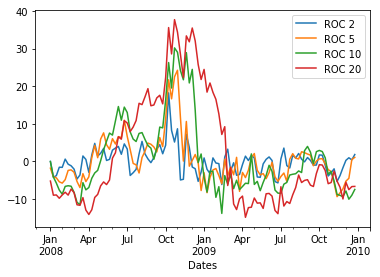

In [10]:
data['2008': '2009'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20']].plot()

# Deviation from zero-lag exponential MA

In [11]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

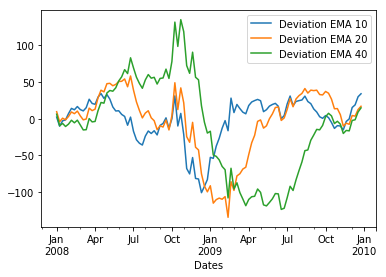

In [12]:
data['2008':'2009'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [13]:
for i, j, k in [(12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

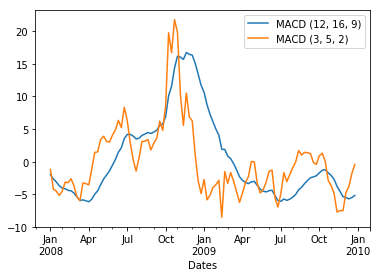

In [14]:
data['2008':'2009'][['MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [16]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [17]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

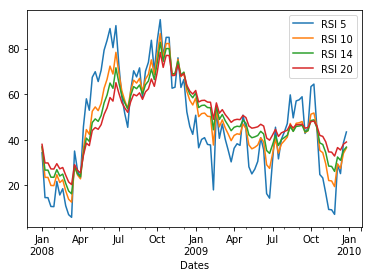

In [18]:
data['2008':'2009'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [19]:
for i, j in [(5, 10), (10, 20)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

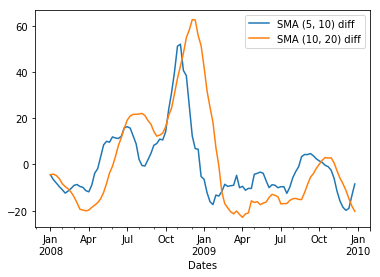

In [20]:
data['2008':'2009'][['SMA (5, 10) diff', 'SMA (10, 20) diff']].plot()

# ADX

In [21]:
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)

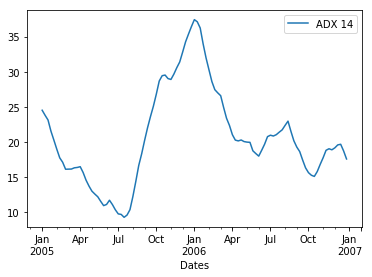

In [22]:
data['2005':'2006'][['ADX 14']].plot()

# CCI

In [23]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

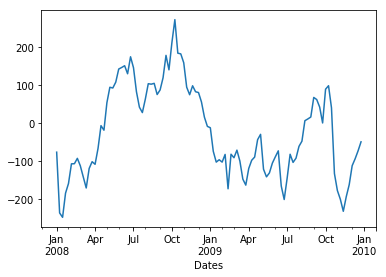

In [24]:
data['2008':'2009']['CCI 14'].plot()

# Y target value

In [25]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Extreme'] = data['Close'].pct_change(return_day).rolling(return_day).std()*100

In [26]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (12, 16, 9)","MACD (3, 5, 2)",RSI 5,RSI 10,RSI 14,RSI 20,"SMA (5, 10) diff","SMA (10, 20) diff",ADX 14,CCI 14,Return,Extreme
Dates,,,,,,,,,,,,,,,,,,,
2004-10-03,-0.950430,-3.565731,-4.773533,-5.258621,-3.145266,-33.071905,-39.414000,-1.063577,-3.861377,19.825401,34.272946,41.114504,46.984882,-11.395,-6.1890,23.131563,-149.550770,-1.968732,1.846438
2004-10-10,-2.877405,-4.189450,-7.175132,-7.218502,-1.318854,-33.379343,-46.271854,-1.860784,-4.879007,14.557762,29.792533,37.437672,44.189530,-12.000,-8.4765,23.788964,-163.745237,-3.726395,2.343418
2004-10-17,0.719663,-1.345001,-5.045621,-3.670886,15.480028,-16.183691,-34.079324,-1.949907,-2.230049,42.969704,42.352674,45.334744,48.982102,-10.425,-10.5515,23.417572,-96.015734,-7.769382,1.947023
2004-10-24,2.182123,-0.245801,-4.830767,-5.576237,18.242751,-11.263816,-34.076674,-1.982963,-0.983722,42.901381,42.320443,45.311144,48.965143,-7.635,-11.8440,22.543811,-59.526914,-8.706366,1.778628
2004-10-31,0.813075,0.057059,-2.818463,-5.431433,22.253160,-2.310119,-29.563178,-1.790757,0.429008,52.368375,46.817456,48.214271,50.759614,-5.785,-11.8615,21.732462,-39.499532,-7.046843,1.770833


### Features

In [27]:
feature_names = data.drop(['Return', 'Extreme'], axis=1).columns

# Train and test Random Forest

In [28]:
def to_class(y_vec, extreme):
    pos = y_vec > extreme
    neg = y_vec <= -1*extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [29]:
def make_X_y(df):
    X = df.drop(['Return', 'Extreme'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y, extreme_val) # df['Extreme']
    return X, y, ret

In [30]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    train_ret = ret.iloc[:train_size]
    test_ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    train_ret = pd.concat([train_ret, train_ret[-last_q4:], train_ret[-last_q8:], train_ret[-last_q16:]], ignore_index=True)
    
    return X_train, X_test, y_train, y_test, train_ret, test_ret

In [31]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [32]:
def calculate_returns(ret, y_pred, log=True):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    if log:
        print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred, ret):
#     bad_sum     = -8*np.sum(((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos')))
#     np_sum      = -2*np.sum(((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg')))
#     pn_sum      = -1*np.sum(((y_true == 'Pos') & (y_pred == 'Neutral')) | ((y_true == 'Neg') & (y_pred == 'Neutral')))
#     good_sum    =  10*np.sum(((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg')))
#     return bad_sum + np_sum + pn_sum + good_sum
    actual_returns = ret.iloc[y_true.index]
    return calculate_returns(actual_returns, y_pred, log=False) 

In [34]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [ ]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, train_ret, test_ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [100],
              'forest__max_depth': [3,None],
              'forest__max_features': [3,5],
              'forest__min_samples_split': [2,5],
              'forest__min_samples_leaf': [1,2,5,10,20],
#               'pca__n_components': [0.3, 0.7]
             }
    scorer = make_scorer(custom_loss, greater_is_better=True, ret=train_ret)
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring='accuracy', #
                        cv=3)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(test_ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
        'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [ ]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 2004-10-03 00:00:00 to 2007-11-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    158
Pos     56
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-26.749050570314992 [long] + 0.0 [short] = -26.749050570314992
From 2004-11-07 00:00:00 to 2007-12-30 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    163
Pos     51
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-39.278744205679644 [long] + 0.0 [short] = -39.278744205679644
From 2004-12-12 00:00:00 to 2008-02-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    164
Pos     50
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 36.629858296821894 [short] = 36.629858296821894
From 2005-01-16 00:00:00 to 2008-03-09 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    168
Pos     46
Name: Return, dtype: int64
--

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + -2.810310823709461 [short] = -2.810310823709461
From 2005-02-20 00:00:00 to 2008-04-13 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    172
Pos     42
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -50.550843025482074 [short] = -50.550843025482074
From 2005-03-27 00:00:00 to 2008-05-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    174
Pos     40
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
14.390270625616285 [long] + -31.80323947628947 [short] = -17.412968850673185
From 2005-05-01 00:00:00 to 2008-06-22 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    166
Pos     48
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -28.3932975527458 [short] = -28.3932975527458
From 2005-06-05 00:00:00 to 2008-07-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    148
Pos     66
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -38.13165915107959 [short] = -38.13165915107959
From 2005-07-10 00:00:00 to 2008-08-31 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    132
Pos     82
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -129.06331886148686 [short] = -129.06331886148686
From 2005-08-14 00:00:00 to 2008-10-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    117
Pos     97
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
80.50321224857598 [long] + -28.910749013462222 [short] = 51.592463235113755
From 2005-09-18 00:00:00 to 2008-11-09 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    108
Pos    106
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
-13.817644814413466 [long] + 0.0 [short] = -13.817644814413466
From 2005-10-23 00:00:00 to 2008-12-14 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    116
Neg     98
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-37.01047659522095 [long] + 0.0 [short] = -37.01047659522095
From 2005-11-27 00:00:00 to 2009-01-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    125
Neg     89
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-29.663074036683554 [long] + 0.0 [short] = -29.663074036683554
From 2006-01-01 00:00:00 to 2009-02-22 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    113
Neg    101
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
-22.937151452612394 [long] + 0.0 [short] = -22.937151452612394
From 2006-02-05 00:00:00 to 2009-03-29 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    118
Pos     96
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-22.767442243962567 [long] + 1.1117898594990794 [short] = -21.655652384463487
From 2006-03-12 00:00:00 to 2009-05-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    129
Pos     85
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 33.715182335764695 [short] = 33.715182335764695
From 2006-04-16 00:00:00 to 2009-06-07 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    137
Pos     77
Name: Return, 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-16.252301233316913 [long] + 2.620989092449433 [short] = -13.63131214086748
From 2006-05-21 00:00:00 to 2009-07-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    147
Pos     67
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.50      0.67         2
        Pos       0.75      1.00      0.86         3

avg / total       0.85      0.80      0.78         5

---
Confusion matrix
 [[1 1]
 [0 3]]
8.410470225380939 [long] + 3.0381096206804736 [short] = 11.448579846061413
From 2006-06-25 00:00:00 to 2009-08-16 00:00:00
Split result befor

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
15.166121926221809 [long] + 0.0 [short] = 15.166121926221809
From 2007-01-21 00:00:00 to 2010-03-14 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    150
Pos     64
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.50      0.67      0.57         3

avg / total       0.30      0.40      0.34         5

---
Confusion matrix
 [[0 2]
 [1 2]]
3.0474289418316425 [long] + -4.9734427812650805 [short] = -1.926013839433438
From 2007-02-25 00:00:00 to 2010-04-18 00:00:00
Split result before upsampling:

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
1.4707626545763075 [long] + -9.232169746051234 [short] = -7.7614070914749265
From 2007-04-01 00:00:00 to 2010-05-23 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    124
Pos     90
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.33      0.33         3
        Pos       0.00      0.00      0.00         2

avg / total       0.20      0.20      0.20         5

---
Confusion matrix
 [[1 2]
 [2 0]]
-6.981377077161444 [long] + -6.4588877970602425 [short] = -13.440264874221686
From 2007-05-06 00:00:00 to 2010-06-27 00:00:00
Split result b

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-29.13783847968313 [long] + 0.0 [short] = -29.13783847968313
From 2007-06-10 00:00:00 to 2010-08-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    111
Pos    103
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-23.228641674436833 [long] + 15.093239814237636 [short] = -8.135401860199197
From 2007-07-15 00:00:00 to 2010-09-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    113
Pos    101
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 21.575716516882615 [short] = 21.575716516882615
From 2007-08-19 00:00:00 to 2010-10-10 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    119
Pos     95
Name: Return, d

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 2.437416736601028 [short] = 2.437416736601028
From 2007-12-02 00:00:00 to 2011-01-23 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    141
Pos     73
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.33      0.33         3
        Pos       0.00      0.00      0.00         2

avg / total       0.20      0.20      0.20         5

---
Confusion matrix
 [[1 2]
 [2 0]]
-5.669228847839214 [long] + 0.05933011558734158 [short] = -5.609898732251873
From 2008-01-06 00:00:00 to 2011-02-27 00:00:00
Split result before upsampling: 1

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-7.2781124272708775 [long] + 1.766475369615772 [short] = -5.511637057655106
From 2008-02-10 00:00:00 to 2011-04-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    127
Pos     87
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-7.860421401714491 [long] + 3.0880830030788786 [short] = -4.772338398635612
From 2008-03-16 00:00:00 to 2011-05-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    130
Pos     84
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + -0.006046244786805932 [short] = -0.006046244786805932
From 2008-04-20 00:00:00 to 2011-06-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    137
Pos     77
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 2.812274203662357 [short] = 2.812274203662357
From 2008-05-25 00:00:00 to 2011-07-17 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    147
Pos     67
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + -12.342828315527187 [short] = -12.342828315527187
From 2008-06-29 00:00:00 to 2011-08-21 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    143
Pos     71
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
13.261539133663902 [long] + -33.91153028746185 [short] = -20.64999115379795
From 2008-08-03 00:00:00 to 2011-09-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    141
Pos     73
Name: Return, dtype: int64
---
Distribution:
Pos    4
Neg    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.25      1.00      0.40         1
        Pos       1.00      0.25      0.40         4

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 0]
 [3 1]]
8.24022953527801 [long] + -24.54117273561257 [short] = -16.300943200334558
From 2008-09-07 00:00:00 to 2011-10-30 00:00:00
Split result befor

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 21.002631567217442 [short] = 21.002631567217442
From 2008-11-16 00:00:00 to 2012-01-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    122
Pos     92
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 31.68683139178322 [short] = 31.68683139178322
From 2008-12-21 00:00:00 to 2012-02-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    117
Pos     97
Name: Return, dtype: int64
---
Di

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.8989622119769058 [short] = 0.8989622119769058
From 2009-01-25 00:00:00 to 2012-03-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    121
Pos     93
Name: Return, dtype: int64
---
Distribution:
Pos    4
Neg    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + -11.33100237038732 [short] = -11.33100237038732
From 2009-03-01 00:00:00 to 2012-04-22 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    133
Pos     81
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -18.91360642634343 [short] = -18.91360642634343
From 2009-04-05 00:00:00 to 2012-05-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    128
Pos     86
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 4.909263461096702 [short] = 4.909263461096702
From 2009-05-10 00:00:00 to 2012-07-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    119
Pos     95
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 24.67760592637193 [short] = 24.67760592637193
From 2009-06-14 00:00:00 to 2012-08-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    108
Neg    106
Name: Return, dtype: int64
---
Dist

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
3.404608314369395 [long] + -1.7577045696067994 [short] = 1.6469037447625956
From 2009-09-27 00:00:00 to 2012-11-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    131
Pos     83
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.25      0.40         4
        Pos       0.25      1.00      0.40         1

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 3]
 [0 1]]
-4.076549126956952 [long] + 2.6712597207038224 [short] = -1.4052894062531291
From 2009-11-01 00:00:00 to 2012-12-23 00:00:00
Split result bef

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-4.605280416931734 [long] + 0.828261278785225 [short] = -3.777019138146509
From 2009-12-06 00:00:00 to 2013-01-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    116
Pos     98
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.67      0.80         3
        Pos       0.67      1.00      0.80         2

avg / total       0.87      0.80      0.80         5

---
Confusion matrix
 [[2 1]
 [0 2]]
-0.04776310697517383 [long] + 2.264319650152302 [short] = 2.2165565431771284
From 2010-01-10 00:00:00 to 2013-03-03 00:00:00
Split result befo

In [ ]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [ ]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [ ]:
params.sort_values('Sum of return', ascending=False)

In [ ]:
params.describe()

In [ ]:
params['Sum of return'].sum()

In [ ]:
params['Accuracy'].plot()

In [ ]:
params['Sum of return'].plot()

### Feature importances

In [ ]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [ ]:
features.idxmax(axis=1).value_counts()

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

In [ ]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')